# ExploringTemporalData-Copy1

In [39]:
import pandas as pd
import numpy as np
from pprint import pprint
import random
import networkx as nx 
import matplotlib.pyplot as plt 

import collections


In [40]:
'''Need source for code
'''

class GraphVisualization: 
   
    def __init__(self): 
          
        # visual is a list which stores all  
        # the set of edges that constitutes a 
        # graph 
        self.visual = [] 
          
    # addEdge function inputs the vertices of an 
    # edge and appends it to the visual list 
    def addEdge(self, a, b): 
        temp = [a, b] 
        self.visual.append(temp) 
          
    # In visualize function G is an object of 
    # class Graph given by networkx G.add_edges_from(visual) 
    # creates a graph with a given list 
    # nx.draw_networkx(G) - plots the graph 
    # plt.show() - displays the graph 
    def visualize(self): 
        G = nx.Graph() 
        G.add_edges_from(self.visual) 
        nx.draw_networkx(G) 
        plt.show() 
  

## Generating My Own Data

- At some point n_bod_symbols should be specified as a range e.g. [2,4] and then a random value chosen for it
- Use constants for any string values that are repeated e.g. 'leaf_nodes','event_a','prob'. The other way to do this would be to use a class or named tuples (https://pymotw.com/2/collections/namedtuple.html). In this case I'd probably use constants or named tuples. Only worth using classes if more complex.
- a_value might end up being > than max value 100000
- The current data structure for the pattern (i.e. patt) only allows one root and a list of leaves coming from that. Going forward you will need to be able to add deeper branches plus other properties like negation, disjunction and cycles. This pattern is best described as a 'graph' which consists of a list of vertices (i.e. the symbols) and edges which are described by a start symbol and end symbol. In our case the edges will also have a time interval and boolean properties for negation,disjunction. As a general rule you should pick a data structure that best matches your data, in this case its graphs. Start with a list of symbols and a list of edges. The edges will contain several values, perhaps using a named tuple.
- Pass parameters into create_patterns() that define the low/high of probability, time interval and possible other things like whether to allow disjunction, negation, cycles.  Disjunction, negation and cycles should be part of the pattern definition (patt) rather than being decided during generate_instance()
- Generate the noise outside of generate_instances(). The noise will be spread uniformly over the whole time range [0,100000] and not related to any individual instance

### Assumptions:

- Body symbols : body symbols & root symbol == antecedent ???
- Head: a or any symbol excluding body symbols == consequent ???

- Every Pattern contains a root node
- Not Every Pattern *instance* has an A node, if so it ends at root node.

- every reference pattern has a antecendent & consequent

- The root node is the only node with a time point, the rest of the nodes sit within time intervals.
- Each node in the pattern needs to connect to at least one node.
- A body node/symbol cannot end on itself, e.g [start_symbol= b, end_symbol=b] : temporal constraint
- The A node can end on itself.
- All symbols in the pattern are unique.
- There can be only 1 root nodes ???
- There can be only be 0 or 1 A node for instance

- A conjunction is simply two or more body symbols appearing before a specific root node time point?
    or is it when a body symbol occurs within the time interval of a neighbouring body symbol.
    
- Reference pattern time intervals are relative to the root node 


### Plan

- Make a function that creates the reference pattern (temporal association rule with zero noise, e.g pure pattern)
- Input conf, support into the pattern 

- Distribute generated instances across time scale
- Introduce noise

- Make a .pred file which is just the time interval of the antecedent (node a), symbol (a), probability (confidence)
- Generate files for training (patterns randomised with noise.) from above dot point 


### Ideas  for my research

Crypto currency and sentiment analysis combined with time series analysis in context of GameStop

In [41]:
body_constr = [0,20]
head_constr = [0,10]

BODY_CONST = 'body'
HEAD_CONST = 'head'
ROOT_CONST = 'root'
A = 'a'
always = 100

In [42]:
def time_interval(body_constr): return tuple(np.random.uniform(body_constr)) 

def unique_body_symbols(low=3, high=5, single=False):
    '''Creates a random unique list of symbols for the body 
    of pattern. Symbol A has been excluded from the list as it is reserved 
    for the head of the pattern.
        Args: 
            n_body_symbols (int): amount of body symbols
            
        Returns:
            random_symbols (list): random choice of symbols
    '''
    symbols = ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'] # possible body symbols
    n_bod_symbols = np.random.randint(low, high)
    if single:  n_bod_symbols = 1 
    rand_symbols = random.sample(symbols, k=n_bod_symbols)
    
    return rand_symbols

def make_edges(Edge, body_symbols, condition):
    n_body_symbols = 2 if condition == 'conjunction' or condition == 'disjunction' else 1
    
    edges = []
    connected_nodes = []
    
    for _ in range(n_body_symbols):
        sym = body_symbols.pop()
        start_t, end_t = time_interval(body_constr)
        rand_end_s = np.random.choice(connected_nodes + [ROOT_CONST])
        
        if condition == 'disjunction':
            edges.append(Edge(BODY_CONST, sym, ROOT_CONST, start_t, end_t, prob=always, disjunction=True))
        if condition == 'conjunction':
            edges.append(Edge(BODY_CONST, sym, ROOT_CONST, start_t, end_t, prob=always, conjunction=True))
        if condition == 'negation':
            edges.append(Edge(BODY_CONST, sym, rand_end_s, start_t, end_t, prob=always, negation=True))
        if condition == 'cycle':
            edges.append(Edge(BODY_CONST, sym, rand_end_s, start_t, end_t, prob=always, cycle=True))                    
        connected_nodes.append(sym)

    return edges, connected_nodes


def create_pattern(low_body=4, high_body=6, low_prob=60, high_prob=90, disjunction=False,
                   negation=False, conjunction=False, prob=always, cycle=False): # remove time high
    
    body_symbols = unique_body_symbols(low_body, high_body)
    rand_num = np.random.uniform(low=0, high=always)
    prob = np.random.uniform(low=low_prob, high=high_prob)
    connected_nodes = [] # keep track of connected nodes for end_symbol possibilities
    
    pattern = [] # pattern list of edges : graph like object
    fields = ('type', 'start_s', 'end_s', 'start_t', 'end_t', 'disjunction', 'negation', 'conjunction', 'cycle', 'prob')
    Edge = collections.namedtuple('Edge', fields)
    Edge.__new__.__defaults__ = (False,) * len(Edge._fields) # set defaults
    
    start_t, end_t = time_interval(head_constr)
    pattern.append(Edge(ROOT_CONST, ROOT_CONST, A, # edge for root --> a
                           start_t=start_t,
                           end_t=end_t, prob=prob))
        
    if disjunction:        
        edges, nodes = make_edges(Edge, body_symbols, condition='disjunction') # CONSTANTS???
        pattern.extend(edges)
        connected_nodes.append(nodes)
        pattern.append(Edge(BODY_CONST, nodes[0], nodes[1], # disjunction edge
                    start_t, end_t, disjunction=True, prob=always))
        
    if negation:
        edges, nodes = make_edges(Edge, body_symbols, condition='negation')
        pattern.extend(edges)
        connected_nodes.append(nodes) 
        
    if cycle:
        edges, nodes = make_edges(Edge, body_symbols, condition='cycle')
        pattern.extend(edges)
        connected_nodes.append(nodes)
        
    if conjunction:
        edges, nodes = make_edges(Edge, body_symbols, condition='conjunction')
        pattern.extend(edges)
        connected_nodes.append(nodes)

    # remaining nodes are added to either root or connected body node
    edges, nodes = make_edges(Edge, body_symbols, condition=disjunction)
    pattern.extend(edges)
    connected_nodes.append(nodes)

    return pattern

def plot_pattern(pattern):
    G = GraphVisualization() 
    for p in pattern: G.addEdge(p.start_s, p.end_s)
    G.visualize()


## Visualisations of Reference Patterns (disregarding time dimension).

### Example of Disjunction

disjunction edge could be: add prop disjunction, start_t ... == None

cycle will have to have a disjunction to stop.

negation add prop.

[Edge(type='root', start_s='root', end_s='a', start_t=0.58148906289689495, end_t=8.6549226749180264, disjunction=False, negation=False, conjunction=False, cycle=False, prob=80.80343995713602),
 Edge(type='body', start_s='f', end_s='root', start_t=0.17536259511409336, end_t=6.1842376200128175, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(type='body', start_s='h', end_s='root', start_t=0.083159543135339575, end_t=10.363164442140162, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(type='body', start_s='f', end_s='h', start_t=0.58148906289689495, end_t=8.6549226749180264, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100)]


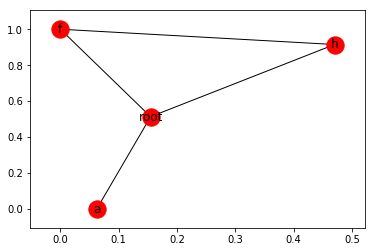

[Edge(type='root', start_s='root', end_s='a', start_t=0.53257873880777606, end_t=2.7751187164523721, disjunction=False, negation=False, conjunction=False, cycle=False, prob=83.43562022078483),
 Edge(type='body', start_s='i', end_s='root', start_t=0.4887536187208672, end_t=8.1012303277371203, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(type='body', start_s='j', end_s='root', start_t=0.99814498925179784, end_t=12.46059367882372, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(type='body', start_s='i', end_s='j', start_t=0.53257873880777606, end_t=2.7751187164523721, disjunction=True, negation=False, conjunction=False, cycle=False, prob=100)]


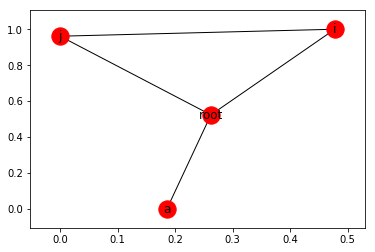

In [43]:
for _ in range(2): 
    ref_pattern = create_pattern(low_body=3, high_body=5, disjunction=True)
    pprint(ref_pattern)
    plot_pattern(ref_pattern)

### Example of Negation

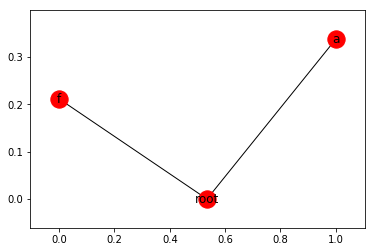

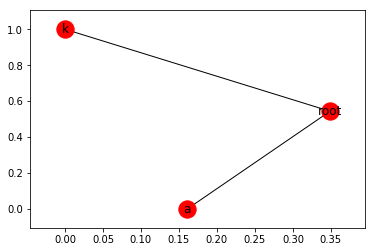

In [44]:
for _ in range(2): 
    ref_pattern = create_pattern(low_body=3, high_body=5, disjunction=False, negation=True)
    plot_pattern(ref_pattern)

### Example of Conjunction

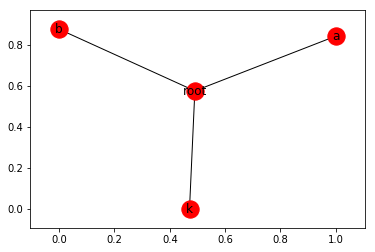

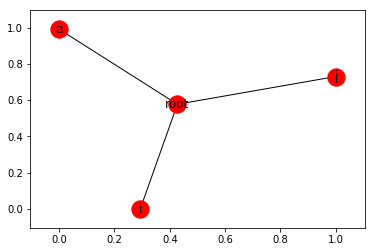

In [45]:
# Raised the low threshold to be able to perform both operators.
for _ in range(2): 
    ref_pattern = create_pattern(low_body=3, high_body=6, conjunction=True, prob=None)
    plot_pattern(ref_pattern)

## Generating Training Set
<br>
Now that we have our reference pattern, we are going to try to build out a training set, basically a noisy dataset (noise we can control) with our reference pattern distributed randomly amongst the noise (level of support???)

In [54]:
patt = create_pattern(low_body=3, high_body=5, disjunction=True)

def time_point(start_t, end_t): return np.random.uniform(start_t, end_t)

def get_root(patt, time_high): # extract root time point and symbol
    for edge in patt: 
        if edge.type == ROOT_CONST: 
            return np.random.uniform(0, time_high), edge.start_s # random root time point

def create_instance(patt, time_high=100000, n_instances=1): # creation of the instances: create instance
    '''
    Returns:
        ts (list): list of lists of time point and symbol adhereing
        to pattern definition'''
    ts = [] # empty time series list

    for n in range(n_instances):
        rand_num = np.random.uniform(low=0, high=100)
        root_tp, root_s = get_root(patt, time_high=time_high)
        ts.append([root_tp, root_s])

        for edge in patt:
            if edge.type == BODY_CONST: 
                ts.append([root_tp - time_point(edge.start_t, edge.end_t), edge.start_s])

            if edge.type == ROOT_CONST: # randomly append consequent
                if rand_num > edge.prob:
                    ### INSERT LOGIC: to retrieve A and it's relative time point
                    ts.append([root_tp + time_point(edge.start_t, edge.end_t), edge.end_s])

#     ts.sort(key=lambda x: x[0]) # sort by timestamp
    
    return ts

ts = create_instance(patt, n_instances=4)

In [55]:
ts

[[26143.01643783239, 'root'],
 [26140.54254605812, 'e'],
 [26141.98902360185, 'c'],
 [26140.01123218861, 'e'],
 [77907.40847038456, 'root'],
 [77905.87208896867, 'e'],
 [77906.58260399885, 'c'],
 [77903.3371319722, 'e'],
 [42977.91708301025, 'root'],
 [42976.58176884194, 'e'],
 [42976.32368274544, 'c'],
 [42974.86374094732, 'e'],
 [63686.55183652841, 'root'],
 [63685.86721778151, 'e'],
 [63685.09889162714, 'c'],
 [63685.2295082154, 'e']]

## Making Noise!

**Time Series Consists of: **<br>
- Singular Pattern replicated over time line
- Random Subsets of the Pattern (func: rand_subset)
- Individual Noisy Symbols

These three types are randomly controlled (probablility of each occuring). Then, combined to create the training/test set. 

In [75]:
def rand_subset(pattern, time_high=100000): # random subset of the instance
    '''
    Returns:
        ts (list): list of lists of time point and symbol of
        random subset of the pattern definition'''
    subset_idxs = sorted([np.random.randint(low=0, high=len(pattern)) for _ in range(2)])
    pattern = pattern[subset_idxs[0]: subset_idxs[1]]
    
    root_tp = time_point(start_t=0, end_t=time_high)
    
    ts = [[root_tp - time_point(edge.start_t, edge.end_t), edge.start_s] for edge in pattern]
    
    return ts 

def noisy_instance(time_high=100000):
    ''' Input: 
            time_high (int): 
    
            Returns:
                ts (list): list of lists containing random time point and symbol'''
    
    sym = unique_body_symbols(single=True).pop()
    tp = time_point(start_t=0, end_t=time_high)
    inst = [[tp, sym]]
    return inst

def create_train(pattern, patt_prob=0.2, subset_prob=0.2, noisy_inst_prob=0.5, n_iter=10):
    '''Returns:
            ts (list): time series for training set  
    '''
    train = []
    
    for _ in range(n_iter):
        rand_num = np.random.uniform(low=0, high=1)

        if rand_num > patt_prob: train.extend(create_instance(pattern))
        if rand_num > subset_prob: train.extend(rand_subset(pattern))
        if rand_num > noisy_inst_prob: train.extend(noisy_instance())

    train.sort(key=lambda x: x[0])
    
    pprint(train)
    
create_train(patt)

[[943.4690310233286, 'e'],
 [944.8983168329164, 'c'],
 [945.0128060585686, 'e'],
 [946.8624047528018, 'root'],
 [2942.12022228803, 'root'],
 [2943.3154468723824, 'e'],
 [13454.857093859197, 'g'],
 [14196.58823462841, 'e'],
 [14197.189352857915, 'c'],
 [14197.450028076157, 'e'],
 [14198.75042069152, 'root'],
 [14200.24299102403, 'a'],
 [20417.656186520082, 'e'],
 [20418.51889516416, 'c'],
 [20418.99554768091, 'e'],
 [20421.117421229574, 'root'],
 [29414.470587312928, 'root'],
 [34990.59743026717, 'e'],
 [37715.26277235509, 'e'],
 [37715.26994890713, 'c'],
 [37715.95609537502, 'e'],
 [37717.028588941525, 'root'],
 [39406.52594640984, 'e'],
 [39409.70273353839, 'c'],
 [39409.850603297804, 'e'],
 [39410.71121427013, 'root'],
 [41853.817096641345, 'root'],
 [41855.0990385129, 'e'],
 [43135.53303901243, 'c'],
 [45991.41298711824, 'g'],
 [51664.47045092032, 'c'],
 [51665.46090649083, 'e'],
 [51666.415143971695, 'e'],
 [51666.79945221857, 'root'],
 [51668.415964820924, 'a'],
 [69995.7617448323

### TODO: Creating .pred file

Every time a pattern instance (NOT a subset or noisy instance) contains the consequent, *a* get the relvent time point and write to file.

In [ ]:
''' 
'''

In [ ]:

def create_pattern(symbols):
    '''Create Dictionary of leaf nodes, root node (from body symbols)
    and event_a (head). Appropriate time intervals are assigned to the 
    nodes. Additionally, probability is assigned
        Args:
            symbols: list of symbols'''
    
    patt = {}
    # randomly select a symbol to be the root node    
    patt['root_node'] = symbols.pop(random.randrange(len(symbols)))
    
    leafs = []
    for sym in symbols:
        # create a random time interval conforming to body constraint
        st, et = time_interval(body_constr)
        # create array with time point from interval and it's relevent symbol
        leafs.append([np.random.uniform(low=st, high=et), sym])
    
    patt['leaf_nodes'] = leafs
    patt['event_a'] = A
    patt['prob'] = np.random.uniform(low=60, high=90)
    
    return patt
    

class Pattern:
    '''Class to Generate data from pattern dictionary.
        Args:
            n_body_symbols (int):  desired amount of body symbols.
            noise (float): amount of noise.
            cycle (bool): determine if pattern is repeated.
            disjunction (bool): disjuntion pattern if True, else conjunction.
            n_patterns (int): used by generate_instances to create n instances
                            of a pattern
            print_patt (bool): Used for validation to see a 'pretty' version 
                            of the pattern.
            
    '''
    def __init__(self, n_bod_symbols, noise, cycle, disjunction,
                 n_patterns=1, print_patt=False):
        
        self.n_bod_symbols = n_bod_symbols
        self.bod_symbols = unique_body_symbols(n_bod_symbols)
        self.noise = noise
        self.cycle = cycle
        self.disjunction = disjunction
        self.patt = create_pattern(self.bod_symbols)
        self.n_patterns = n_patterns
        self.print_patt = print_patt

    def generate_instance(self):       
        rand_num = np.random.uniform(low=0, high=100)
        root_value = np.random.uniform(low=0, high=100000)
        a_value = root_value + np.random.uniform(low=0, high=10) # [0,10] head constraint
        
        # for each leaf node subtract the relevent time point from the root nodes value
        inst = [[root_value - leaf[0], leaf[1]] for leaf in self.patt['leaf_nodes']]
        inst.append([root_value, self.patt['root_node']]) # add root node & value

        
        if self.patt['prob'] > rand_num: # if probability is greater than random num create symbol a
            inst.append([a_value, self.patt['event_a']])

        if self.noise > rand_num / 100: # divide by 100 for decimal comparison
            # create new symbol (MAY BE REPEATED SYMBOL FROM PATTERN, PROBLEM?)
            noisy_symbol = unique_body_symbols(1) 
            inst.append([root_value - np.random.uniform(low=0, high=20), noisy_symbol.pop()])
            
        if self.print_patt: pprint(self.patt) # pretty print of pattern

        inst.sort(key=lambda x: x[0]) # sort by timestamp
        return inst
    
    def generate_instances(self):
        insts = []
        for i in range(self.n_patterns):
            p = Pattern(self.n_bod_symbols, self.noise, self.cycle, self.disjunction)
            insts.extend(p.generate_instance())
        
        insts.sort(key=lambda x: x[0])
        return insts


In [ ]:
# generate instance from reference pattern

# for all type=body, get time point from interval and subtract from root time

for i, n in ref_pattern.items():
    if n.type == BODY_CONST: 
        print(n)
    if n.

### Example 1.
##### Conjunction with 2 body symbols, 0 Noise

In [ ]:
# SEEDS NOT WORKING?
np.random.seed(0)
random.seed(0)

In [ ]:
p = Pattern(n_bod_symbols=2, noise=0, cycle=False, disjunction=False, n_patterns=1, print_patt=True)
l = p.generate_instance()
l

### Example 2.
##### Conjunction with 4 body symbols, 0.9 Noise

In [ ]:
p = Pattern(n_bod_symbols=4, noise=0.99, cycle=False, disjunction=False, n_patterns=1, print_patt=True)
l = p.generate_instance()
l

Notice 99% of the time a new noisy symbol is introduced into the output

### Example 3.
##### Disjunction with 3 body symbols, Noise = 0

In [ ]:
p = Pattern(n_bod_symbols=3, noise=0, cycle=False, disjunction=True, n_patterns=1, print_patt=True)
l = p.generate_instance()
l

Notice one of the leaf nodes has been removed from the pattern

### Example 4.
##### Conjunction with 0 Noise and a Cycle

In [ ]:
p = Pattern(n_bod_symbols=3, noise=0, cycle=True, disjunction=False, n_patterns=1, print_patt=True)
l = p.generate_instance()
l

Unsure if this is correct output, is the initial pattern supposed to precede the second repeated pattern?

## Output Singluar Conjuntion Pattern with 100 repititions

In [ ]:
p = Pattern(n_bod_symbols=3, noise=0.5, cycle=False, disjunction=False, n_patterns=10, print_patt=False)
output = p.generate_instances()

In [ ]:
with open('output_conjunction_nsym3_n1000.txt', 'w') as file:
    for l in output:
        s = str(l[0]) + ' ,' + str(l[1]) + '\n'
        file.write(s)

In [ ]:
# convert to pandas Dataframe for easy plotting
df = pd.read_table('./output_conjunction_nsym3_n1000.txt', names=['time', 'symbol'], sep=',')

values = df['symbol'].to_list()
names = df['time'].to_list()

plt.scatter(names, values);

## TODO: 
- Generate .pred file
- Negation? not 100% on how to implement this.
- Different types of Noise?